In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy import stats

%matplotlib inline

# Reading and cleaning datasets

In [2]:
# reading csv files and creating dataframes
df_evandro = pd.read_csv('Evandro.csv', sep=';', encoding='latin-1')
df_celso = pd.read_csv('Celso.csv', sep=';', encoding='latin-1')
df_eliezer = pd.read_csv('Eliezer.csv', sep=';', encoding='latin-1')
df_rafael = pd.read_csv('Rafael.csv', sep=',', encoding='latin-1')
df_thiago = pd.read_csv('Thiago.csv', sep=';', encoding='latin-1')

# drop NaN values (if any)
df_evandro.dropna(inplace=True)
df_celso.dropna(inplace=True)
df_eliezer.dropna(inplace=True)
df_rafael.dropna(inplace=True)
df_thiago.dropna(inplace=True)

# drop useless data
df_evandro.drop(['Date', 'Time', 'Event Type'], axis=1, inplace=True)
df_celso.drop(['Date', 'Time', 'Event Type'], axis=1, inplace=True)
df_eliezer.drop(['Date', 'Time', 'Event Type'], axis=1, inplace=True)
df_rafael.drop(['Date', 'Time', 'Event Type'], axis=1, inplace=True)
df_thiago.drop(['Date', 'Time', 'Event Type'], axis=1, inplace=True)

# getting rid of outliers by calculating the Z-score across all columns and deleting 
# rows whose any of the values is below the threshold
df_evandro = df_evandro[(np.abs(stats.zscore(df_evandro)) < 2).all(axis=1)].reset_index(drop=True)
df_celso = df_celso[(np.abs(stats.zscore(df_celso)) < 2).all(axis=1)].reset_index(drop=True)
df_eliezer = df_eliezer[(np.abs(stats.zscore(df_eliezer)) < 2).all(axis=1)].reset_index(drop=True)
df_rafael = df_rafael[(np.abs(stats.zscore(df_rafael)) < 2).all(axis=1)].reset_index(drop=True)
df_thiago = df_thiago[(np.abs(stats.zscore(df_thiago)) < 2).all(axis=1)].reset_index(drop=True)

# DAQUI EM DIANTE, DEIXAR APENAS OS DOIS QUE ESTÃO SENDO TESTADOS

# set the maximum row numbers
#maxRows = [df_evandro.shape[0], df_celso.shape[0]]
#maxRows.sort()

maxRows = [df_eliezer.shape[0], df_thiago.shape[0]]
maxRows.sort()

# slice dataframes in order to equalize the length
#df_evandro = df_evandro.loc[:maxRows[0]-1,:]
#df_celso = df_celso.loc[:maxRows[0]-1,:]
df_eliezer = df_eliezer.loc[:maxRows[0]-1,:]
#df_rafael = df_rafael.loc[:maxRows[0]-1,:]
df_thiago = df_thiago.loc[:maxRows[0]-1,:]

#print(df_evandro.shape[0], df_celso.shape[0])
print(df_eliezer.shape[0], df_thiago.shape[0])

216730 216730


# Methods for creating new variables and standardizing datasets

In [3]:
def createFeatures(df):
    offset_list, xm_list, ym_list, xstd_list, ystd_list, distm_list, diststd_list, arct_list = ([] for i in range(8))

    # deleting rows with coordinate X being 0
    df = df[df['Coordinate X'] != 0]

    # filtering unique id == 1 
    ulist = df['EventId'].unique()
    for u in ulist:
        df_unique = df[df['EventId'] == u]
        if df_unique.shape[0] == 1: # original is "== 1"
            df = df[df['EventId'] != u]

    # list of unique id with occurrence > 1
    ulist = df['EventId'].unique()

    for u in ulist:
        df_unique = df[df['EventId'] == u]

        # adding mean
        x_mean = df_unique['Coordinate X'].mean()
        y_mean = df_unique['Coordinate Y'].mean()
        xm_list.append(x_mean)
        ym_list.append(y_mean)
        
        # adding std
        xstd_list.append(df_unique['Coordinate X'].std())
        ystd_list.append(df_unique['Coordinate Y'].std())

        # calculating euclidean distances
        arr = np.array([(x, y) for x, y in zip(df_unique['Coordinate X'], df_unique['Coordinate Y'])])
        dist = [np.linalg.norm(arr[i+1]-arr[i]) for i in range(arr.shape[0]-1)]
        ideal_dist = np.linalg.norm(arr[arr.shape[0]-1]-arr[0])

        # adding offset
        offset_list.append(sum(dist)-ideal_dist)

        # adding distance mean
        distm_list.append(np.asarray(dist).mean())

        # adding distance std deviation
        diststd_list.append(np.asarray(dist).std())

    # create df subset with the new features
    df_subset = pd.DataFrame(ulist, columns=['EventId'])
    
    df_subset['Dist Mean'] = distm_list
    df_subset['Dist Std Dev'] = diststd_list
    df_subset['Offset'] = offset_list

    # drop EventId
    df_subset.drop(['EventId'], axis=1, inplace=True)
    
    return df_subset

def standardize(df):
    # instanciate StandardScaler object
    scaler = StandardScaler()

    # compute the mean and std to be used for later scaling
    scaler.fit(df)

    # perform standardization by centering and scaling
    scaled_features = scaler.transform(df)

    return pd.DataFrame(scaled_features)

In [4]:
# creating new features from existing variables
#df_evandro = createFeatures(df_evandro)
#df_celso = createFeatures(df_celso)
df_eliezer = createFeatures(df_eliezer)
#df_rafael = createFeatures(df_rafael)
df_thiago = createFeatures(df_thiago)

# Shuffling and splitting into training and testing dataset

In [18]:
# set the maximum row numbers
maxRows = [df_eliezer.shape[0], df_thiago.shape[0]]
#(ALTERAR PARA CADA TESTE DIFERENTE)
#df_evandro.shape[0], df_celso.shape[0], #df_eliezer.shape[0], #df_rafael.shape[0], #df_thiago.shape[0]
maxRows.sort()

# slice dataframes in order to equalize the length
#df_evandro = df_evandro.loc[:maxRows[0]-1,:]
#df_celso = df_celso.loc[:maxRows[0]-1,:]
df_eliezer = df_eliezer.loc[:maxRows[0]-1,:]
#df_rafael = df_rafael.loc[:maxRows[0]-1,:]
df_thiago = df_thiago.loc[:maxRows[0]-1,:]

print(df_eliezer.shape[0], df_thiago.shape[0])
#(ALTERAR PARA CADA TESTE DIFERENTE)
#df_evandro.shape[0], df_celso.shape[0], df_eliezer.shape[0], #df_rafael.shape[0], #df_thiago.shape[0]

42236 42236


# RODAR VÁRIAS VEZES A PARTIR DAQUI

In [61]:
# RODAR VÁRIAS VEZES A PARTIR DAQUI, CADA VEZ O DATASET VAI SER MISTURADO E A ACURÁCIA PODE SER DIFERENTE

#df_evandro_shuffle = df_evandro.sample(frac=1).reset_index(drop=True)
#df_celso_shuffle = df_celso.sample(frac=1).reset_index(drop=True)
df_eliezer_shuffle = df_eliezer.sample(frac=1).reset_index(drop=True)
#df_rafael_shuffle = df_rafael.sample(frac=1).reset_index(drop=True)
df_thiago_shuffle = df_thiago.sample(frac=1).reset_index(drop=True)

# PESSOA QUE QUER VERIFICAR (70% DE DADOS PRA TREINO E 30% PARA TESTE)
#df_evandro_train = df_evandro_shuffle.loc[:(df_evandro_shuffle.shape[0]-1)*0.7]
#df_evandro_test = df_evandro_shuffle.loc[(df_evandro_shuffle.shape[0]*0.7):]

df_eliezer_train = df_eliezer_shuffle.loc[:(df_eliezer_shuffle.shape[0]-1)*0.7]
df_eliezer_test = df_eliezer_shuffle.loc[(df_eliezer_shuffle.shape[0]*0.7):]

# OUTRA PESSOA (NÃO PRECISA DO DATASET DE TESTE, PEGA APENAS 70% PARA TREINO)
#df_celso_train = df_celso_shuffle.loc[:(df_celso_shuffle.shape[0]-1)*0.7]

df_thiago_train = df_thiago_shuffle.loc[:(df_thiago_shuffle.shape[0]-1)*0.7]

In [62]:
# standardizing training datasets

# PADRONIZAR TREINO E TESTE DA PESSOA QUE QUER VERIFICAR (ALTERAR PARA CADA TESTE DIFERENTE)
#df_evandro_train = standardize(df_evandro_train)
#df_evandro_test = standardize(df_evandro_test)

df_eliezer_train = standardize(df_eliezer_train)
df_eliezer_test = standardize(df_eliezer_test)

# PADRONIZAR TREINO DA OUTRA PESSOA (ALTERAR PARA CADA TESTE DIFERENTE)
#df_celso_train = standardize(df_celso_train)

df_thiago_train = standardize(df_thiago_train)

# Running PCA on training datasets

In [63]:
# applying PCA and concat on train datasets
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

# PCA NO DATASET DE TREINO DA PESSOA QUE QUER VERIFICAR (ALTERAR PARA CADA TESTE DIFERENTE)
#principalComponents = pca.fit_transform(df_evandro_train)
#df_evandro_train = pd.DataFrame(data = principalComponents)

#df_evandro_train['Label'] = ['Evandro' for s in range(df_evandro_train.shape[0])]

principalComponents = pca.fit_transform(df_eliezer_train)
df_eliezer_train = pd.DataFrame(data = principalComponents)

df_eliezer_train['Label'] = ['Eliezer' for s in range(df_eliezer_train.shape[0])]

# PCA NO DATASET DE TESTE DA PESSOA QUE QUER VERIFICAR (ALTERAR PARA CADA TESTE DIFERENTE)

#principalComponents = pca.fit_transform(df_evandro_test)
#df_evandro_test = pd.DataFrame(data = principalComponents)

#df_evandro_test['Label'] = ['Evandro' for s in range(df_evandro_test.shape[0])]

principalComponents = pca.fit_transform(df_eliezer_test)
df_eliezer_test = pd.DataFrame(data = principalComponents)

df_eliezer_test['Label'] = ['Eliezer' for s in range(df_eliezer_test.shape[0])]

# PCA NO DATASET DE TREINO DAS OUTRAS PESSOAS (ALTERAR PARA CADA TESTE DIFERENTE)

#principalComponents = pca.fit_transform(df_celso_train)
#df_celso_train = pd.DataFrame(data = principalComponents)

#df_celso_train['Label'] = ['Celso' for s in range(df_celso_train.shape[0])]

principalComponents = pca.fit_transform(df_thiago_train)
df_thiago_train = pd.DataFrame(data = principalComponents)

df_thiago_train['Label'] = ['Thiago' for s in range(df_thiago_train.shape[0])]

# CONCATENAR OS DOIS DATASETS DE TREINO (ALTERAR PARA CADA TESTE DIFERENTE)
#df_train = pd.concat([df_evandro_train, df_celso_train]).sample(frac=1).reset_index(drop=True)
#df_test = df_evandro_test

df_train = pd.concat([df_eliezer_train, df_thiago_train]).sample(frac=1).reset_index(drop=True)
df_test = df_eliezer_test

df_train.columns = 'PC1 PC2 PC3 Label'.split()
df_test.columns = 'PC1 PC2 PC3 Label'.split()

df_train.head()

,PC1,PC2,PC3,Label
0,2.528171,5.542524,-0.120243,Thiago
1,-0.149771,1.011348,-0.092753,Thiago
2,1.972100,-0.776439,2.841339,Thiago
3,-0.675936,-0.194450,-0.170597,Thiago
4,1.264204,-0.656205,-0.163753,Eliezer


In [64]:
X_train = df_train.drop('Label', axis=1)
Y_train = df_train['Label']

X_test = df_test.drop('Label', axis=1)
Y_test = df_test['Label']

df_train['Label'].value_counts()

Thiago     29565
Eliezer    29565
Name: Label, dtype: int64

Text(0,0.5,'Error Rate')

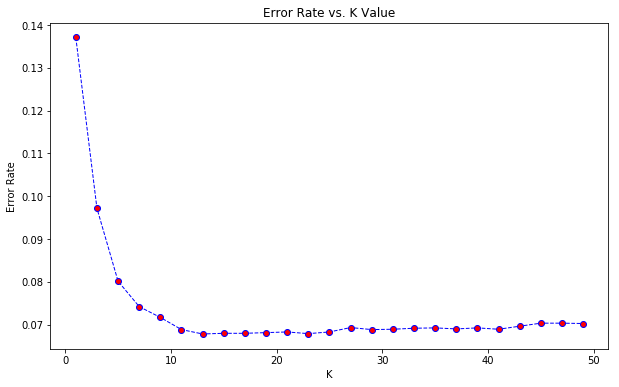

In [65]:
# Looking for the best k parameter
error_rate = []

for i in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    error_rate.append(np.mean(Y_pred != Y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,50,2), error_rate, color='blue', lw=1, ls='dashed', marker='o', markerfacecolor='red')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [66]:
# running KNN
knn = KNeighborsClassifier(n_neighbors=99)
knn.fit(X_train, Y_train)
pred = knn.predict(X_test)

print("Accuracy: {}%".format(round(accuracy_score(Y_test, pred)*100,2)))

Accuracy: 92.57%
